In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import timm
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pickle
import PIL.Image
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from statistics import mean
import torchvision.transforms as transforms
from tqdm import tqdm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from shared_interest.datasets.imagenet import ImageNet
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std
from interpretability_methods.vanilla_gradients import VanillaGradients
from interpretability_methods.gradcam import GradCAM
from interpretability_methods.util import visualize_saliency

In [3]:
models = 'adv_inception_v3, bat_resnext26ts, beit_base_patch16_224, beit_base_patch16_384, beit_large_patch16_224, beit_large_patch16_384, botnet26t_256, cait_s24_224, cait_s24_384, cait_s36_384, cait_xs24_384, cait_xxs24_224, cait_xxs24_384, cait_xxs36_224, cait_xxs36_384, coat_lite_mini, coat_lite_small, coat_lite_tiny, coat_mini, coat_tiny, convit_base, convit_small, convit_tiny, convmixer_1024_20_ks9_p14, convmixer_1536_20, convmixer_768_32, convnext_base, convnext_base_384_in22ft1k, convnext_base_in22ft1k, convnext_large, convnext_large_384_in22ft1k, convnext_large_in22ft1k, convnext_small, convnext_tiny, cspdarknet53, cspresnet50, cspresnext50, deit_base_patch16_224, deit_base_patch16_384, deit_small_patch16_224, deit_tiny_patch16_224, densenet121, densenet161, densenet169, densenet201, densenetblur121d, dla102, dla102x, dla102x2, dla169, dla34, dla46_c, dla46x_c, dla60, dla60_res2net, dla60_res2next, dla60x, dla60x_c, dm_nfnet_f0, dm_nfnet_f1, dm_nfnet_f2, dpn107, dpn131, dpn68, dpn68b, dpn92, dpn98, eca_botnext26ts_256, eca_halonext26ts, eca_nfnet_l0, eca_nfnet_l1, eca_nfnet_l2, eca_resnet33ts, eca_resnext26ts, ecaresnet101d, ecaresnet101d_pruned, ecaresnet269d, ecaresnet26t, ecaresnet50d, ecaresnet50d_pruned, ecaresnet50t, ecaresnetlight, efficientnet_b0, efficientnet_b1, efficientnet_b1_pruned, efficientnet_b2, efficientnet_b2_pruned, efficientnet_b3, efficientnet_b3_pruned, efficientnet_b4, efficientnet_el, efficientnet_el_pruned, efficientnet_em, efficientnet_es, efficientnet_es_pruned, efficientnet_lite0, efficientnetv2_rw_m, efficientnetv2_rw_s, efficientnetv2_rw_t, ens_adv_inception_resnet_v2, ese_vovnet19b_dw, ese_vovnet39b, fbnetc_100, fbnetv3_b, fbnetv3_d, fbnetv3_g, gc_efficientnetv2_rw_t, gcresnet33ts, gcresnet50t, gcresnext26ts, gcresnext50ts, gernet_l, gernet_m, gernet_s, ghostnet_100, gluon_inception_v3, gluon_resnet101_v1b, gluon_resnet101_v1c, gluon_resnet101_v1d, gluon_resnet101_v1s, gluon_resnet152_v1b, gluon_resnet152_v1c, gluon_resnet152_v1d, gluon_resnet152_v1s, gluon_resnet18_v1b, gluon_resnet34_v1b, gluon_resnet50_v1b, gluon_resnet50_v1c, gluon_resnet50_v1d, gluon_resnet50_v1s, gluon_resnext101_32x4d, gluon_resnext101_64x4d, gluon_resnext50_32x4d, gluon_senet154, gluon_seresnext101_32x4d, gluon_seresnext101_64x4d, gluon_seresnext50_32x4d, gmixer_24_224, gmlp_s16_224, halo2botnet50ts_256, halonet26t, halonet50ts, haloregnetz_b, hardcorenas_a, hardcorenas_b, hardcorenas_c, hardcorenas_d, hardcorenas_e, hardcorenas_f, hrnet_w18, hrnet_w18_small, hrnet_w18_small_v2, hrnet_w30, hrnet_w32, hrnet_w40, hrnet_w44, hrnet_w48, hrnet_w64, ig_resnext101_32x16d, ig_resnext101_32x8d, inception_resnet_v2, inception_v3, inception_v4, jx_nest_base, jx_nest_small, jx_nest_tiny, lambda_resnet26rpt_256, lambda_resnet26t, lambda_resnet50ts, lamhalobotnet50ts_256, lcnet_050, lcnet_075, lcnet_100, legacy_senet154, legacy_seresnet101, legacy_seresnet152, legacy_seresnet18, legacy_seresnet34, legacy_seresnet50, legacy_seresnext101_32x4d, legacy_seresnext26_32x4d, legacy_seresnext50_32x4d, mixer_b16_224, mixer_b16_224_miil, mixnet_l, mixnet_m, mixnet_s, mixnet_xl, mnasnet_100, mnasnet_small, mobilenetv2_050, mobilenetv2_100, mobilenetv2_110d, mobilenetv2_120d, mobilenetv2_140, mobilenetv3_large_100, mobilenetv3_large_100_miil, mobilenetv3_rw, nasnetalarge, nf_regnet_b1, nf_resnet50, nfnet_l0, pit_b_224, pit_s_224, pit_ti_224, pit_xs_224, pnasnet5large, regnetx_002, regnetx_004, regnetx_006, regnetx_008, regnetx_016, regnetx_032, regnetx_040, regnetx_064, regnetx_080, regnetx_120, regnetx_160, regnetx_320, regnety_002, regnety_004, regnety_006, regnety_008, regnety_016, regnety_032, regnety_040, regnety_064, regnety_080, regnety_120, regnety_160, regnety_320, regnetz_b16, regnetz_c16, regnetz_d32, regnetz_d8, regnetz_e8, repvgg_a2, repvgg_b0, repvgg_b1, repvgg_b1g4, repvgg_b2, repvgg_b2g4, repvgg_b3, repvgg_b3g4, res2net101_26w_4s, res2net50_14w_8s, res2net50_26w_4s, res2net50_26w_6s, res2net50_26w_8s, res2net50_48w_2s, res2next50, resmlp_12_224, resmlp_12_distilled_224, resmlp_24_224, resmlp_24_distilled_224, resmlp_36_224, resmlp_36_distilled_224, resmlp_big_24_224, resmlp_big_24_224_in22ft1k, resmlp_big_24_distilled_224, resnest101e, resnest14d, resnest200e, resnest269e, resnest26d, resnest50d, resnest50d_1s4x24d, resnest50d_4s2x40d, resnet101, resnet101d, resnet152, resnet152d, resnet18, resnet18d, resnet200d, resnet26, resnet26d, resnet26t, resnet32ts, resnet33ts, resnet34, resnet34d, resnet50, resnet50_gn, resnet50d, resnet51q, resnet61q, resnetblur50, resnetrs101, resnetrs152, resnetrs200, resnetrs270, resnetrs350, resnetrs420, resnetrs50, resnetv2_101, resnetv2_101x1_bitm, resnetv2_50, resnetv2_50x1_bit_distilled, resnetv2_50x1_bitm, resnext101_32x8d, resnext26ts, resnext50_32x4d, resnext50d_32x4d, rexnet_100, rexnet_130, rexnet_150, rexnet_200, sebotnet33ts_256, sehalonet33ts, selecsls42b, selecsls60, selecsls60b, semnasnet_075, semnasnet_100, seresnet152d, seresnet33ts, seresnet50, seresnext26d_32x4d, seresnext26t_32x4d, seresnext26ts, seresnext50_32x4d, skresnet18, skresnet34, skresnext50_32x4d, spnasnet_100, ssl_resnet18, ssl_resnet50, ssl_resnext101_32x16d, ssl_resnext101_32x4d, ssl_resnext101_32x8d, ssl_resnext50_32x4d, swin_base_patch4_window12_384, swin_base_patch4_window7_224, swin_large_patch4_window12_384, swin_large_patch4_window7_224, swin_small_patch4_window7_224, swin_tiny_patch4_window7_224, swsl_resnet18, swsl_resnet50, swsl_resnext101_32x16d, swsl_resnext101_32x4d, swsl_resnext101_32x8d, swsl_resnext50_32x4d, tf_efficientnet_b0, tf_efficientnet_b0_ap, tf_efficientnet_b0_ns, tf_efficientnet_b1, tf_efficientnet_b1_ap, tf_efficientnet_b1_ns, tf_efficientnet_b2, tf_efficientnet_b2_ap, tf_efficientnet_b2_ns, tf_efficientnet_b3, tf_efficientnet_b3_ap, tf_efficientnet_b3_ns, tf_efficientnet_b4, tf_efficientnet_b4_ap, tf_efficientnet_b4_ns, tf_efficientnet_b5, tf_efficientnet_b5_ap, tf_efficientnet_b5_ns, tf_efficientnet_b6, tf_efficientnet_b6_ap, tf_efficientnet_b6_ns, tf_efficientnet_b7, tf_efficientnet_b7_ap, tf_efficientnet_b7_ns, tf_efficientnet_cc_b0_4e, tf_efficientnet_cc_b0_8e, tf_efficientnet_cc_b1_8e, tf_efficientnet_el, tf_efficientnet_em, tf_efficientnet_es, tf_efficientnet_lite0, tf_efficientnet_lite1, tf_efficientnet_lite2, tf_efficientnet_lite3, tf_efficientnet_lite4, tf_efficientnetv2_b0, tf_efficientnetv2_b1, tf_efficientnetv2_b2, tf_efficientnetv2_b3, tf_efficientnetv2_l, tf_efficientnetv2_l_in21ft1k, tf_efficientnetv2_m, tf_efficientnetv2_m_in21ft1k, tf_efficientnetv2_s, tf_efficientnetv2_s_in21ft1k, tf_inception_v3, tf_mixnet_l, tf_mixnet_m, tf_mixnet_s, tf_mobilenetv3_large_075, tf_mobilenetv3_large_100, tf_mobilenetv3_large_minimal_100, tf_mobilenetv3_small_075, tf_mobilenetv3_small_100, tf_mobilenetv3_small_minimal_100, tinynet_a, tinynet_b, tinynet_c, tinynet_d, tinynet_e, tnt_s_patch16_224, tv_densenet121, tv_resnet101, tv_resnet152, tv_resnet34, tv_resnet50, tv_resnext50_32x4d, twins_pcpvt_base, twins_pcpvt_large, twins_pcpvt_small, twins_svt_base, twins_svt_large, twins_svt_small, vgg11, vgg11_bn, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19, vgg19_bn, visformer_small, vit_base_patch16_224, vit_base_patch16_224_miil, vit_base_patch16_384, vit_base_patch32_224, vit_base_patch32_384, vit_base_patch8_224, vit_base_r50_s16_384, vit_small_patch16_224, vit_small_patch16_384, vit_small_patch32_224, vit_small_patch32_384, vit_small_r26_s32_224, vit_small_r26_s32_384, vit_tiny_patch16_224, vit_tiny_patch16_384, vit_tiny_r_s16_p8_224, vit_tiny_r_s16_p8_384, wide_resnet101_2, wide_resnet50_2, xception, xception41, xception65, xception71, xcit_large_24_p16_224, xcit_large_24_p16_224_dist, xcit_large_24_p16_384_dist, xcit_large_24_p8_224, xcit_large_24_p8_224_dist, xcit_large_24_p8_384_dist, xcit_medium_24_p16_224, xcit_medium_24_p16_224_dist, xcit_medium_24_p16_384_dist, xcit_medium_24_p8_224, xcit_medium_24_p8_224_dist, xcit_nano_12_p16_224, xcit_nano_12_p16_224_dist, xcit_nano_12_p16_384_dist, xcit_nano_12_p8_224, xcit_nano_12_p8_224_dist, xcit_nano_12_p8_384_dist, xcit_small_12_p16_224, xcit_small_12_p16_224_dist, xcit_small_12_p16_384_dist, xcit_small_12_p8_224, xcit_small_12_p8_224_dist, xcit_small_12_p8_384_dist, xcit_small_24_p16_224, xcit_small_24_p16_224_dist, xcit_small_24_p8_224, xcit_small_24_p8_224_dist, xcit_small_24_p8_384_dist, xcit_tiny_12_p16_224, xcit_tiny_12_p16_224_dist, xcit_tiny_12_p16_384_dist, xcit_tiny_12_p8_224, xcit_tiny_12_p8_224_dist, xcit_tiny_12_p8_384_dist, xcit_tiny_24_p16_224, xcit_tiny_24_p16_224_dist, xcit_tiny_24_p16_384_dist, xcit_tiny_24_p8_224, xcit_tiny_24_p8_224_dist, xcit_tiny_24_p8_384_dist'.split(", ")
print (len(models))

489


In [4]:
imagenet_dir = ''
image_dir = os.path.join(imagenet_dir, 'images')
annotation_dir = os.path.join(imagenet_dir, 'annotations')

In [5]:
# ImageNet transforms.
image_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225]),
                                     ])

ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256, PIL.Image.NEAREST),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

reverse_image_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], 
                                                                   std=[4.3668, 4.4643, 4.4444]),
                                              transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                                                   std=[1, 1, 1]),
                                              transforms.ToPILImage(),])

In [6]:
dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, 
                                         num_workers=40, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


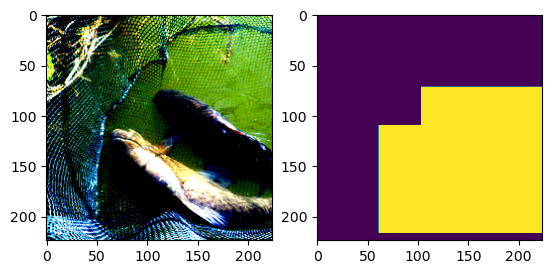

In [7]:
for image, ground_truth, label in dataset:
    print (PIL.Image.NEAREST)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(image.permute(1, 2, 0))
    ax[1].imshow(ground_truth)
    break

In [8]:
def run(model, dataloader, saliency_method):
    model.eval()
    accuracy = 0
    total_iou_score = np.array([])

    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            images = images.to(device)
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()

            # Compute model predictions
            output = model(images)
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()

            # Update metrics
            accuracy += accuracy_score(labels, predictions)
        
        # Compute saliency
        saliency = flatten(saliency_method.get_saliency(images))
        saliency_masks = binarize_std(saliency)

        # Compute Shared Interest scores
        iou_score = shared_interest(ground_truth, saliency_masks, score='iou_coverage')
        total_iou_score = np.concatenate((total_iou_score, iou_score))
        
        # Compute Pointing Game
        for j in range(saliency.shape[0]):
            saliency_batch = saliency[j]
            ground_truth_batch = ground_truth[j]
            pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
            point = ground_truth_batch[pixel[0], pixel[1]]

            # check if most salient feature is in ground truth 
            if point > 0:
                salient_pixel_count += 1
    
    pointing_game = salient_pixel_count / len(dataloader.dataset)

    accuracy /= i + 1
    print('Accuracy: %.2f' %accuracy)
    print('IoU: %.5f' %mean(total_iou_score))
    print('pointing_game: %.2f' %pointing_game)
    
    # add pointing game to the return statement if needed
    return accuracy, mean(total_iou_score)

In [9]:
import shutil
import os

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [ ]:
acc_dict = {}
iou_dict = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_name in models:
    with torch.no_grad():
        try:
            model = timm.create_model(model_name, pretrained=True)
            image_transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
            input_size = model.pretrained_cfg['input_size'][-1]
            ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize(math.floor(input_size / model.pretrained_cfg['crop_pct']), interpolation=PIL.Image.NEAREST, antialias=None),
                                                 transforms.CenterCrop(size=(input_size, input_size)),
                                                 transforms.ToTensor()])
            print (model_name)
        except:
            print (model_name + ' not available!!')
            continue

        if torch.cuda.device_count() > 1:
            print('Using', torch.cuda.device_count(), 'GPUs')
            model = nn.DataParallel(model)
        model = model.to(device)
        param_size = 0
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()

        size_all_mb = (param_size + buffer_size) / 1024**2
        print('model size: {:.3f}MB'.format(size_all_mb))

        hf_cache_dir = ''
        hf_cache_model = get_immediate_subdirectories(hf_cache_dir)
        no_backup_dir = ''
        if len(hf_cache_model) > 1:
            no_backup_model = os.path.join(no_backup_dir, hf_cache_model[-1])
            if os.path.isdir(no_backup_model):
                shutil.rmtree(no_backup_model)
            new_path = shutil.move(os.path.join(hf_cache_dir, hf_cache_model[-1]), no_backup_dir)

        dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)

        if size_all_mb > 1000:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)
        else:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, pin_memory=True)

        saliency_method = VanillaGradients(model)
        acc, iou = run(model, dataloader, saliency_method)
        acc_dict[model_name] = acc
        iou_dict[model_name] = iou


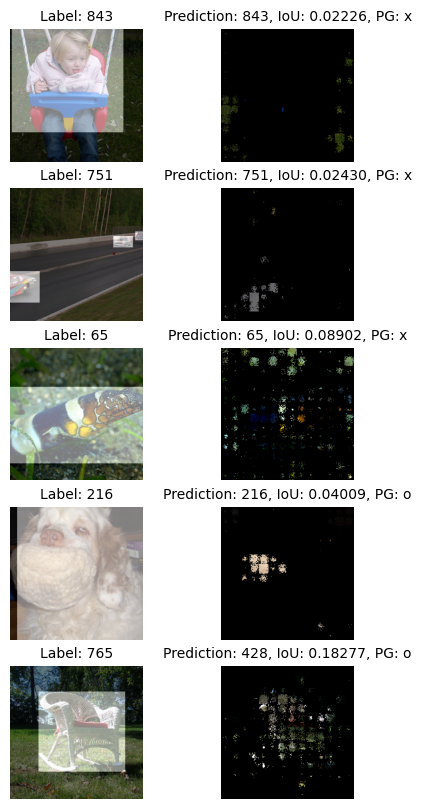

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'convit_tiny'
model = timm.create_model(model_name, pretrained=True)
image_transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
input_size = model.pretrained_cfg['input_size'][-1]
ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(math.floor(input_size / model.pretrained_cfg['crop_pct']), interpolation=PIL.Image.NEAREST, antialias=None),
                                     transforms.CenterCrop(size=(input_size, input_size)),
                                     transforms.ToTensor()])
model = model.to(device)

dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
data = [dataset[i] for i in selected_images]
n = len(selected_images)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(5,10))
np.vectorize(ax_off)(ax)

for i, (image, ground_truth, label) in enumerate(data):
    ax[i][0].imshow(reverse_image_transform(image))
    ax[i][0].imshow(ground_truth, alpha =0.5, cmap='gray')
    ax[i][0].set(frame_on=False)
    ax[i][0].set_title('Label: %s' %(label), fontsize=10)
    image = image.to(device)
    output = model(image.unsqueeze(0))
    predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
    
    saliency_method = VanillaGradients(model)
    saliency = flatten(saliency_method.get_saliency(image.to(device).unsqueeze(0)))
    saliency_masks = binarize_std(saliency)

    saliency_image = np.array(reverse_image_transform(image)) * np.expand_dims(saliency_masks[0], axis=2)

    ax[i][1].imshow(saliency_image)
    ax[i][1].set(frame_on=False)
    iou_coverage = shared_interest(ground_truth.unsqueeze(0).numpy(), saliency_masks, score='iou_coverage')
    pg = 'x'
    for j in range(saliency.shape[0]):
        saliency_batch = saliency[j]
        pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
        point = ground_truth[pixel[0], pixel[1]]

        # check if most salient feature is in ground truth 
        if point > 0:
            pg = 'o'
    ax[i][1].set_title('Prediction: %s, IoU: %.5f'%(predictions[0], iou_coverage) + ", PG: " + pg, fontsize = 10)

[42170, 37573, 3298, 10801, 38253]


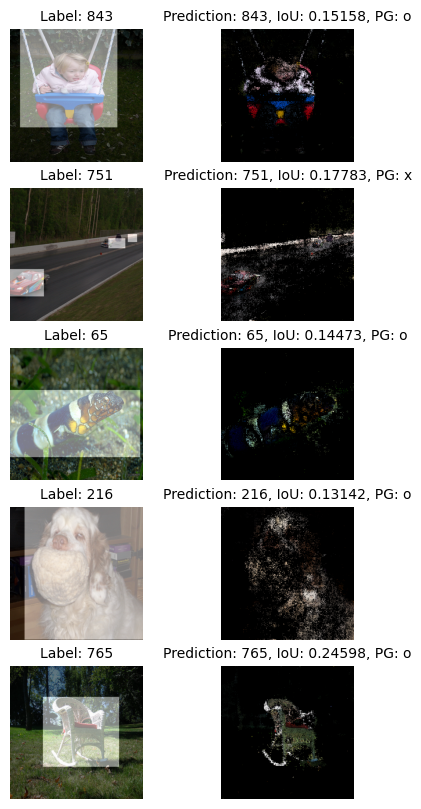

In [66]:
selected_images = random.sample(range(50000), 5)
print (selected_images)
# selected_images = [12960, 12352, 40572, 13530, 234]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# selected_models = ['convit_tiny', 'convnext_base_384_in22ft1k']
model_name = 'convnext_base_384_in22ft1k'
model = timm.create_model(model_name, pretrained=True)
image_transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
input_size = model.pretrained_cfg['input_size'][-1]
ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(math.floor(input_size / model.pretrained_cfg['crop_pct']), interpolation=PIL.Image.NEAREST, antialias=None),
                                     transforms.CenterCrop(size=(input_size, input_size)),
                                     transforms.ToTensor()])
model = model.to(device)

dataset = ImageNet(image_dir, annotation_dir, image_transform, ground_truth_transform)
data = [dataset[i] for i in selected_images]
n = len(selected_images)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(5,10))
np.vectorize(ax_off)(ax)

for i, (image, ground_truth, label) in enumerate(data):
    ax[i][0].imshow(reverse_image_transform(image))
    ax[i][0].imshow(ground_truth, alpha =0.5, cmap='gray')
    ax[i][0].set(frame_on=False)
    ax[i][0].set_title('Label: %s' %(label), fontsize=10)
    image = image.to(device)
    output = model(image.unsqueeze(0))
    predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
    
    saliency_method = VanillaGradients(model)
    saliency = flatten(saliency_method.get_saliency(image.to(device).unsqueeze(0)))
    saliency_masks = binarize_std(saliency)

    saliency_image = np.array(reverse_image_transform(image)) * np.expand_dims(saliency_masks[0], axis=2)

    ax[i][1].imshow(saliency_image)
    ax[i][1].set(frame_on=False)
    iou_coverage = shared_interest(ground_truth.unsqueeze(0).numpy(), saliency_masks, score='iou_coverage')
    pg = 'x'
    for j in range(saliency.shape[0]):
        saliency_batch = saliency[j]
        pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
        point = ground_truth[pixel[0], pixel[1]]

        # check if most salient feature is in ground truth 
        if point > 0:
            pg = 'o'
    ax[i][1].set_title('Prediction: %s, IoU: %.5f'%(predictions[0], iou_coverage) + ", PG: " + pg, fontsize = 10)